<a href="https://www.kaggle.com/code/iwways/backpack-eda-model-tuning?scriptVersionId=220459589" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import optuna

# 1️⃣ Introduction

## 🏆 Overview of the competition

In this playground competition we should predict backpack price based on different features, such as weight capacity, brand, material, size, compartments,  laptop compartment, waterproof, style and color.

## 🎯 Problem statement & objectives

Backpacks are an essential part of everyday life for many people, especially in modern times when individuals carry a wide variety of personal and professional items daily. Whether it’s for work, school, travel, or outdoor activities, backpacks provide the convenience of carrying everything needed for the day. One group that particularly benefits from this versatility is programmers, who often need to carry a range of equipment, from laptops and chargers to notebooks and headphones, all essential to their daily tasks.

This is where our challenge lies: using machine learning to predict key features of backpacks based on their characteristics. The goal is not just to create a predictive model, but to better understand the dataset, create meaningful insights, and ultimately fine-tune our model to predict with greater accuracy 📈.

Our objectives for this notebook are:
* 📊 **Exploratory Data Analysis (EDA):** Conduct a thorough analysis of the dataset to uncover insights about how different features correlate with each other and the target variable 🔍
* 🚀 **Baseline Model:** Establish a simple baseline model to set performance expectations and identify room for improvement 🧑‍💻
* 🛠️**Feature Engineering:** Identify and create new features that may enhance model performance and better represent the data 💡
* 🎛️ **Hyperparameter Tuning:** Optimize model performance by adjusting hyperparameters using Optuna to find the most effective configuration ⚙️
* 📈 **Model Evaluation:** Assess the performance of the model using various metrics and discuss potential improvements moving forward 🎯
Through this journey, we’ll focus on not only building a model but also enhancing our understanding of the data, ensuring that we leverage the best techniques to achieve high predictive accuracy. 💪

# 2️⃣ Exploratory Data Analysis (EDA)

## 📊 Data overview (shape, missing values, types)

Let's take a look on training data.

In [2]:
X_train = pd.read_csv('/kaggle/input/playground-series-s5e2/train.csv')
X_test = pd.read_csv('/kaggle/input/playground-series-s5e2/test.csv')
sample_subm = pd.read_csv('/kaggle/input/playground-series-s5e2/sample_submission.csv')

From first look we're having a small number of columns with categorical and numerical features.

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    300000 non-null  int64  
 1   Brand                 290295 non-null  object 
 2   Material              291653 non-null  object 
 3   Size                  293405 non-null  object 
 4   Compartments          300000 non-null  float64
 5   Laptop Compartment    292556 non-null  object 
 6   Waterproof            292950 non-null  object 
 7   Style                 292030 non-null  object 
 8   Color                 290050 non-null  object 
 9   Weight Capacity (kg)  299862 non-null  float64
 10  Price                 300000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 25.2+ MB


Good, we're have 300k rows and 11 columns in dataset. What about missing values?

In [4]:
X_train.isna().sum()

id                         0
Brand                   9705
Material                8347
Size                    6595
Compartments               0
Laptop Compartment      7444
Waterproof              7050
Style                   7970
Color                   9950
Weight Capacity (kg)     138
Price                      0
dtype: int64

We're having missing values in all columns, except for id, compartments and price. The biggest number of missing values in color and brand column. Is the same thing in test data?

In [5]:
X_test.isna().sum()

id                         0
Brand                   6227
Material                5613
Size                    4381
Compartments               0
Laptop Compartment      4962
Waterproof              4811
Style                   5153
Color                   6785
Weight Capacity (kg)      77
dtype: int64

Yep, the same thing goes here. Now let's take a look on descriptive statistics.

In [6]:
X_train.describe(include='all')

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
count,300000.000000,290295,291653,293405,300000.000000,292556,292950,292030,290050,299862.000000,300000.000000
unique,NaN,5,4,3,NaN,2,2,3,6,NaN,NaN
top,NaN,Adidas,Polyester,Medium,NaN,Yes,Yes,Messenger,Pink,NaN,NaN
freq,NaN,60077,79630,101906,NaN,148342,148077,100031,51690,NaN,NaN
mean,149999.500000,NaN,NaN,NaN,5.443590,NaN,NaN,NaN,NaN,18.029994,81.411107
std,86602.684716,NaN,NaN,NaN,2.890766,NaN,NaN,NaN,NaN,6.966914,39.039340
min,0.000000,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,5.000000,15.000000
25%,74999.750000,NaN,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,12.097867,47.384620
50%,149999.500000,NaN,NaN,NaN,5.000000,NaN,NaN,NaN,NaN,18.068614,80.956120
75%,224999.250000,NaN,NaN,NaN,8.000000,NaN,NaN,NaN,NaN,24.002375,115.018160


## 📈 Visualizing class distributions

Now let's vizualize our class distributions. Starting from numerical features.

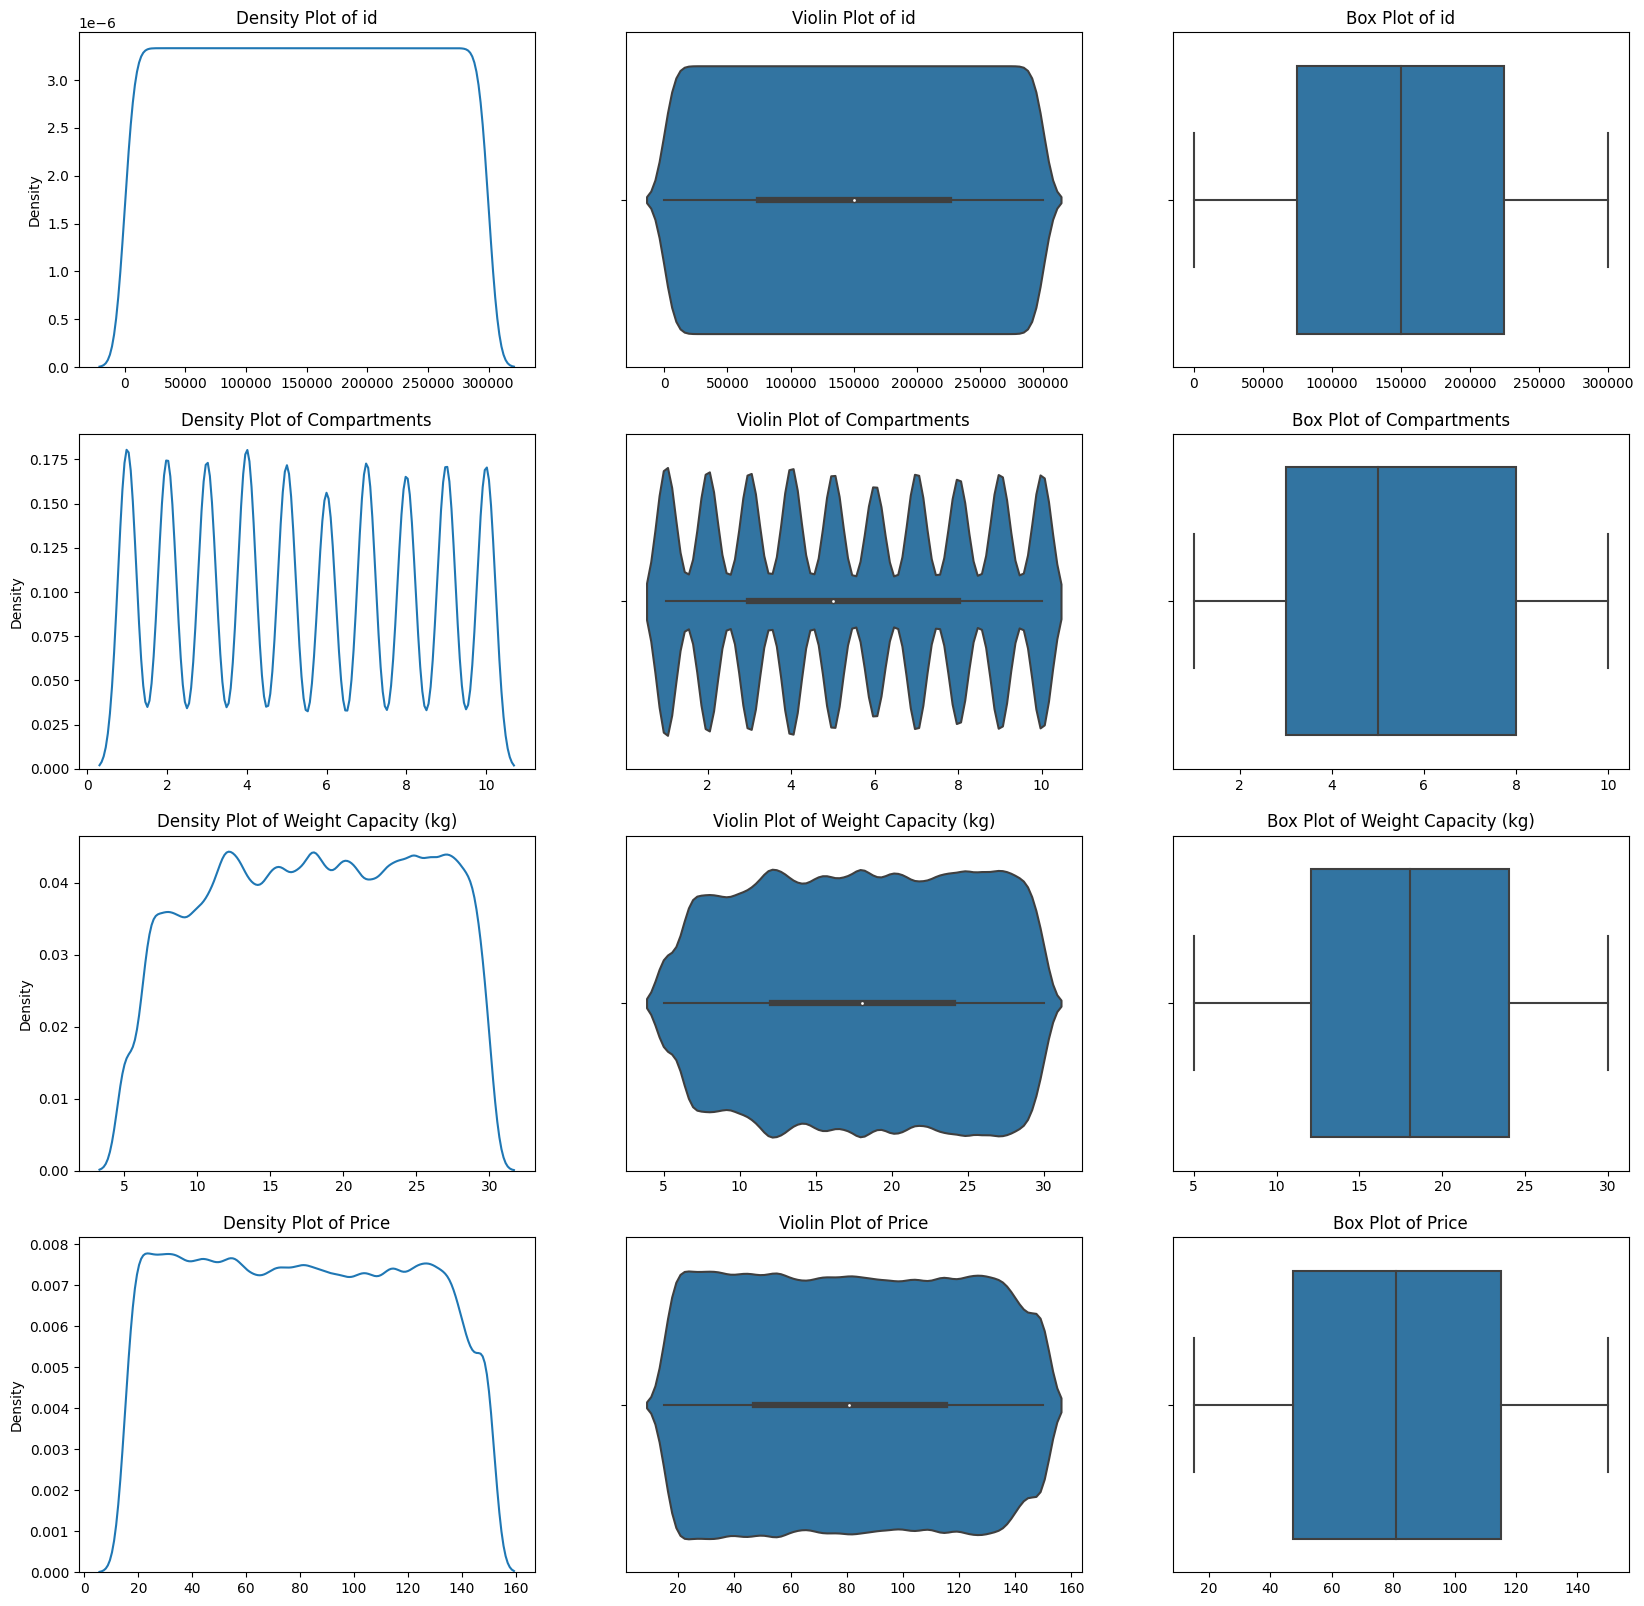

In [7]:
fig, axs = plt.subplots(4,3, figsize=(20,20))
numerical_features = X_train.select_dtypes(exclude='object').columns
r = 0
for feat in numerical_features:
    c = 0
    while c<3:
        if c == 0:
            sns.kdeplot(ax=axs[r, c], data=X_train, x=feat)
            axs[r,c].set_title(f'Density Plot of {feat}')
            axs[r,c].set(xlabel=None)
        elif c == 1:
            sns.violinplot(ax=axs[r,c], data=X_train, x=feat)
            axs[r,c].set_title(f'Violin Plot of {feat}')
            axs[r,c].set(xlabel=None)
        elif c == 2:
            sns.boxplot(ax=axs[r,c], data=X_train, x=feat)
            axs[r,c].set_title(f'Box Plot of {feat}')
            axs[r,c].set(xlabel=None)
        c += 1
    r += 1

And now categorical features.

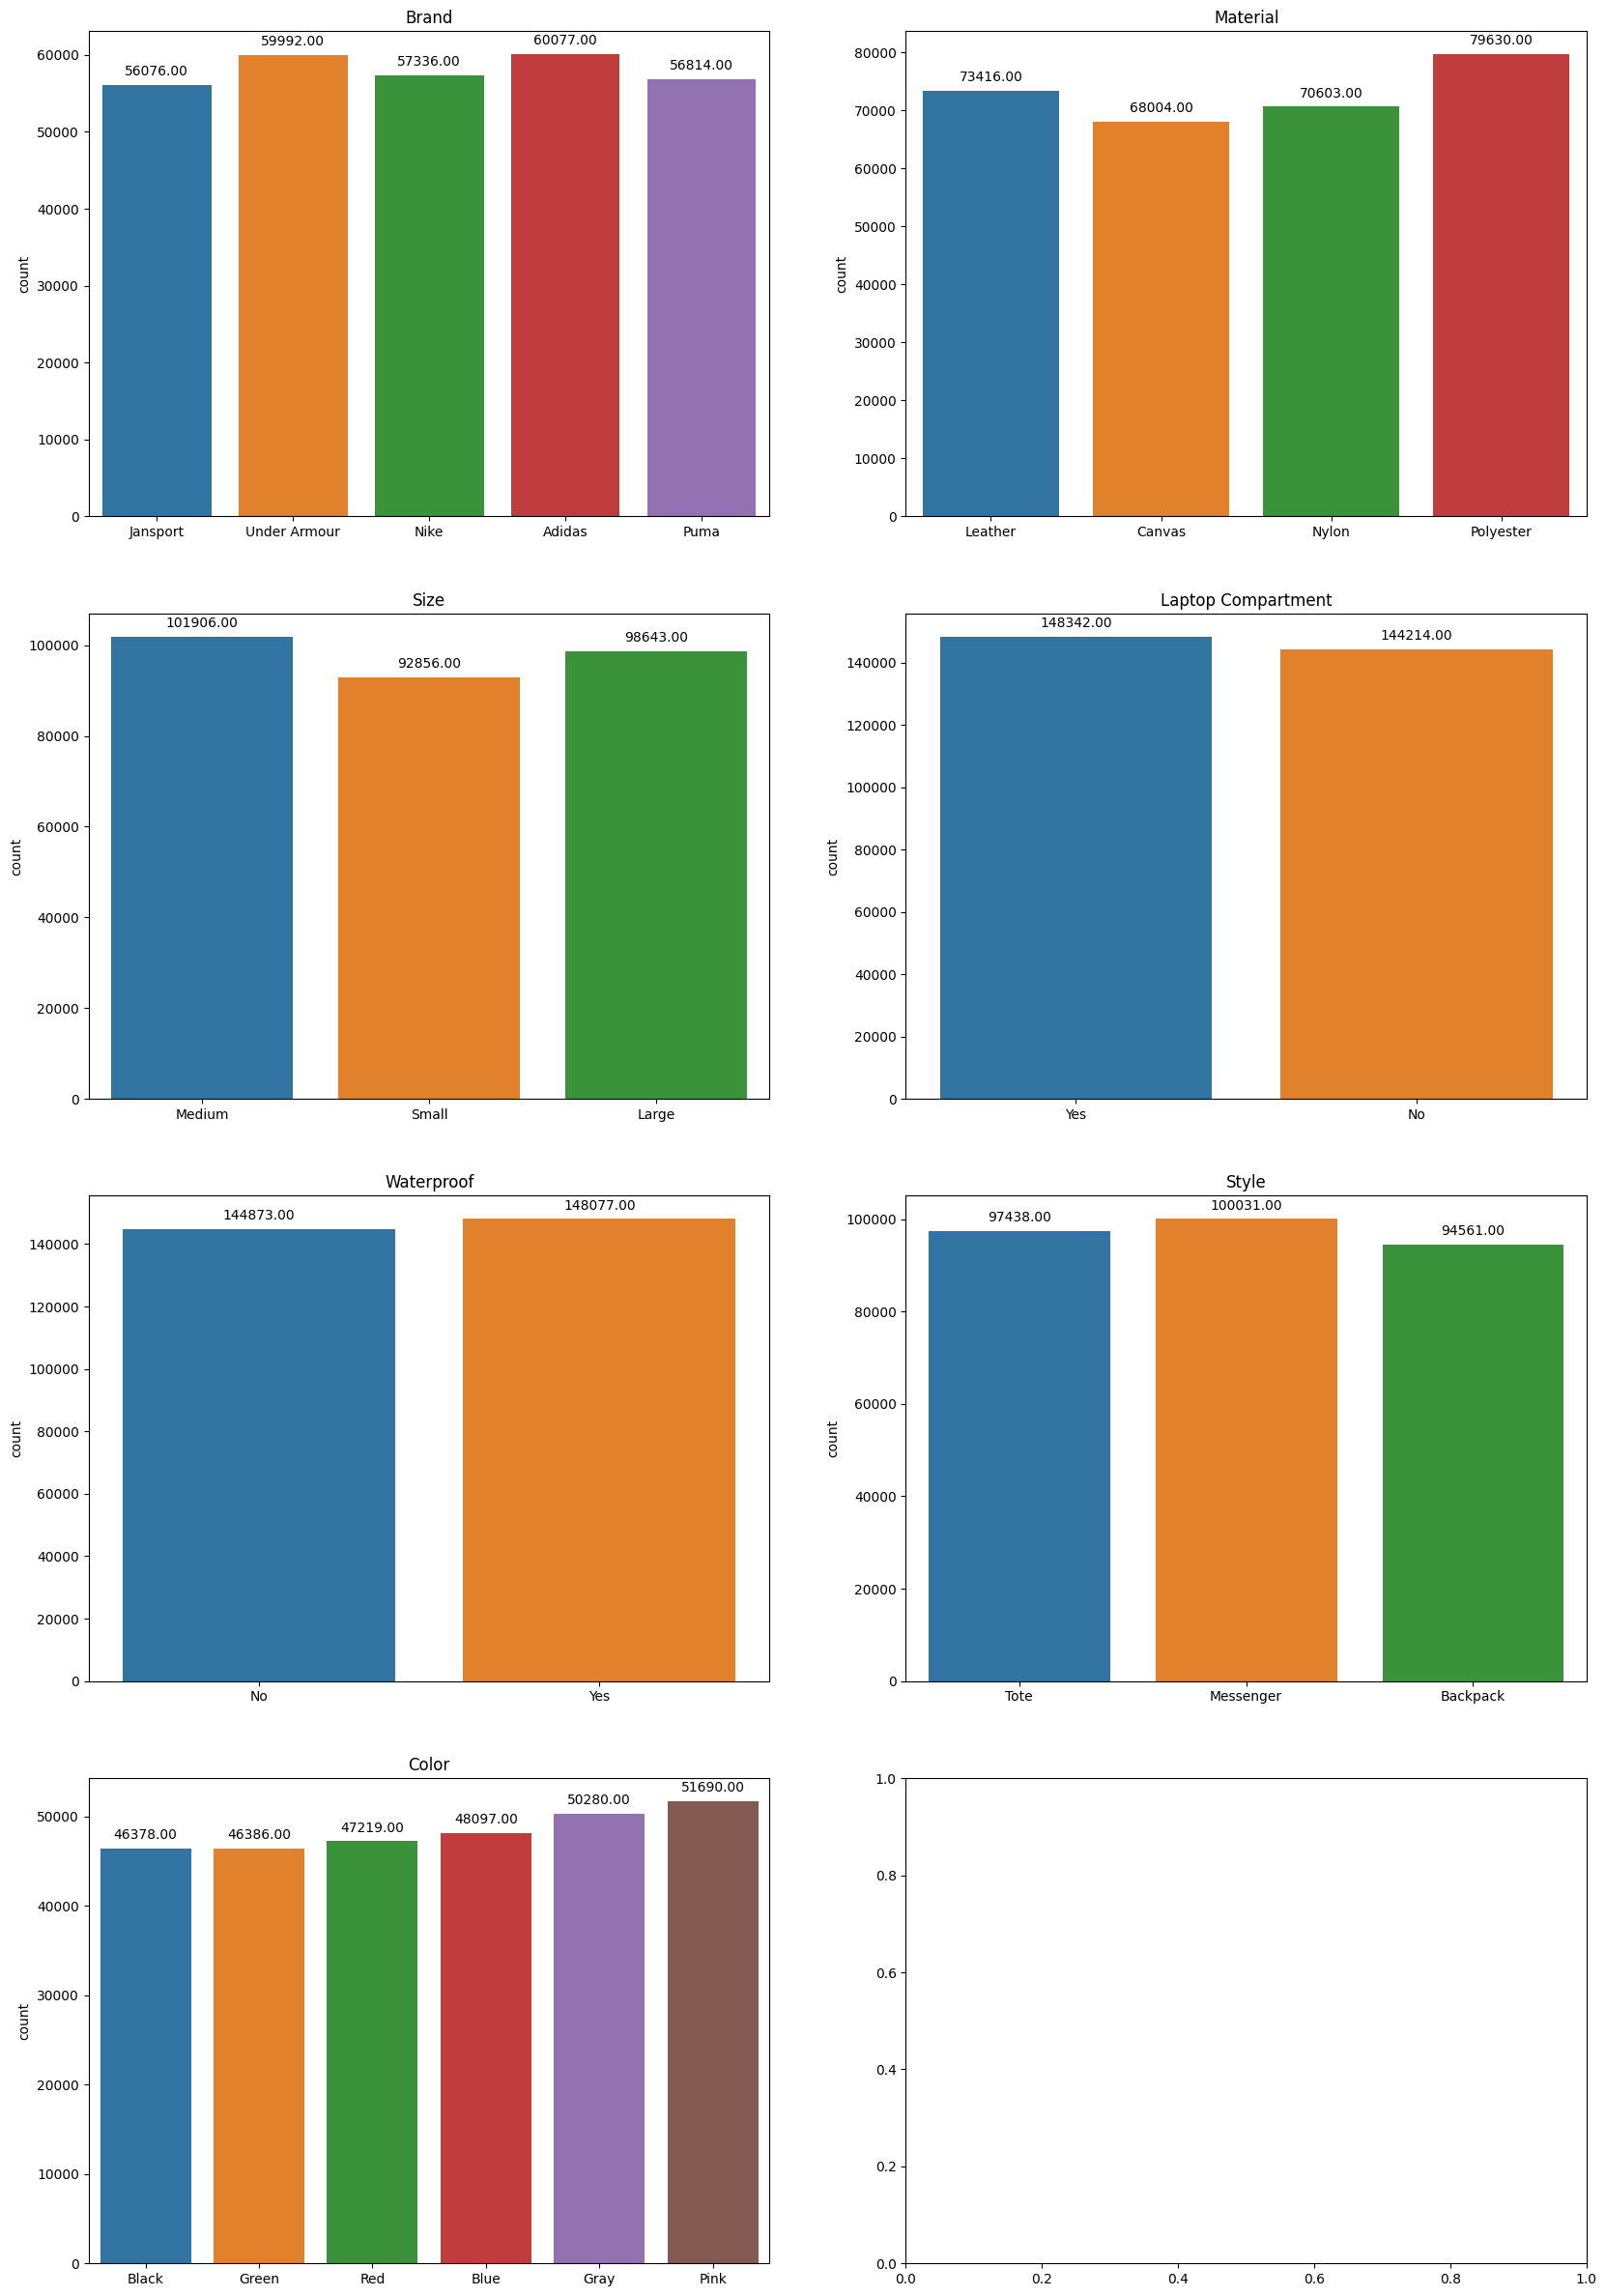

In [8]:
fig, axs = plt.subplots(4,2, figsize=(20,30))
cat_features = X_train.select_dtypes(include='object').columns
r = 0
c = 0
for feat in cat_features:
    if c == 2:
        c = 0
        r += 1
    counts = sns.countplot(ax=axs[r,c], data=X_train, x=feat)
    for p in counts.patches:
        counts.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()),  ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    
    axs[r,c].set_title(f'{feat}')
    axs[r,c].set(xlabel=None)

  
    c += 1

Our features seems to be more or less equally distributed across categories.

## 🔬 Feature correlations & relationships

In this section we'll look at correlation between our features and build graphs features VS price.

<Axes: >

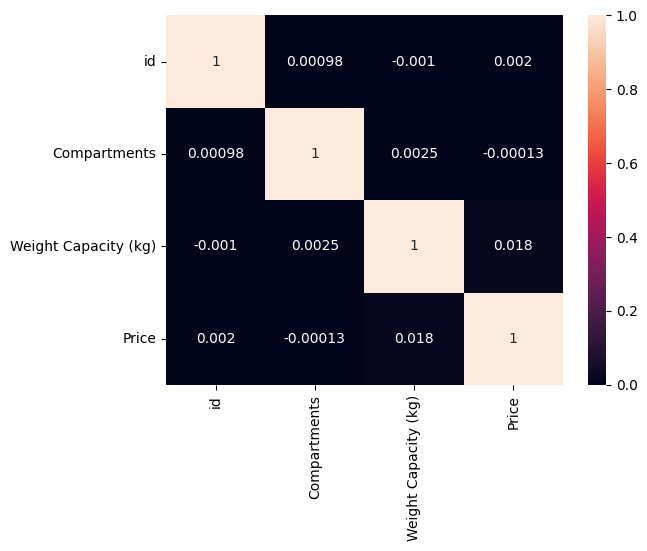

In [9]:
sns.heatmap(X_train[numerical_features].corr(), annot=True)

Our features doesn't have any correlation.

Now let's take a look on features vs target.

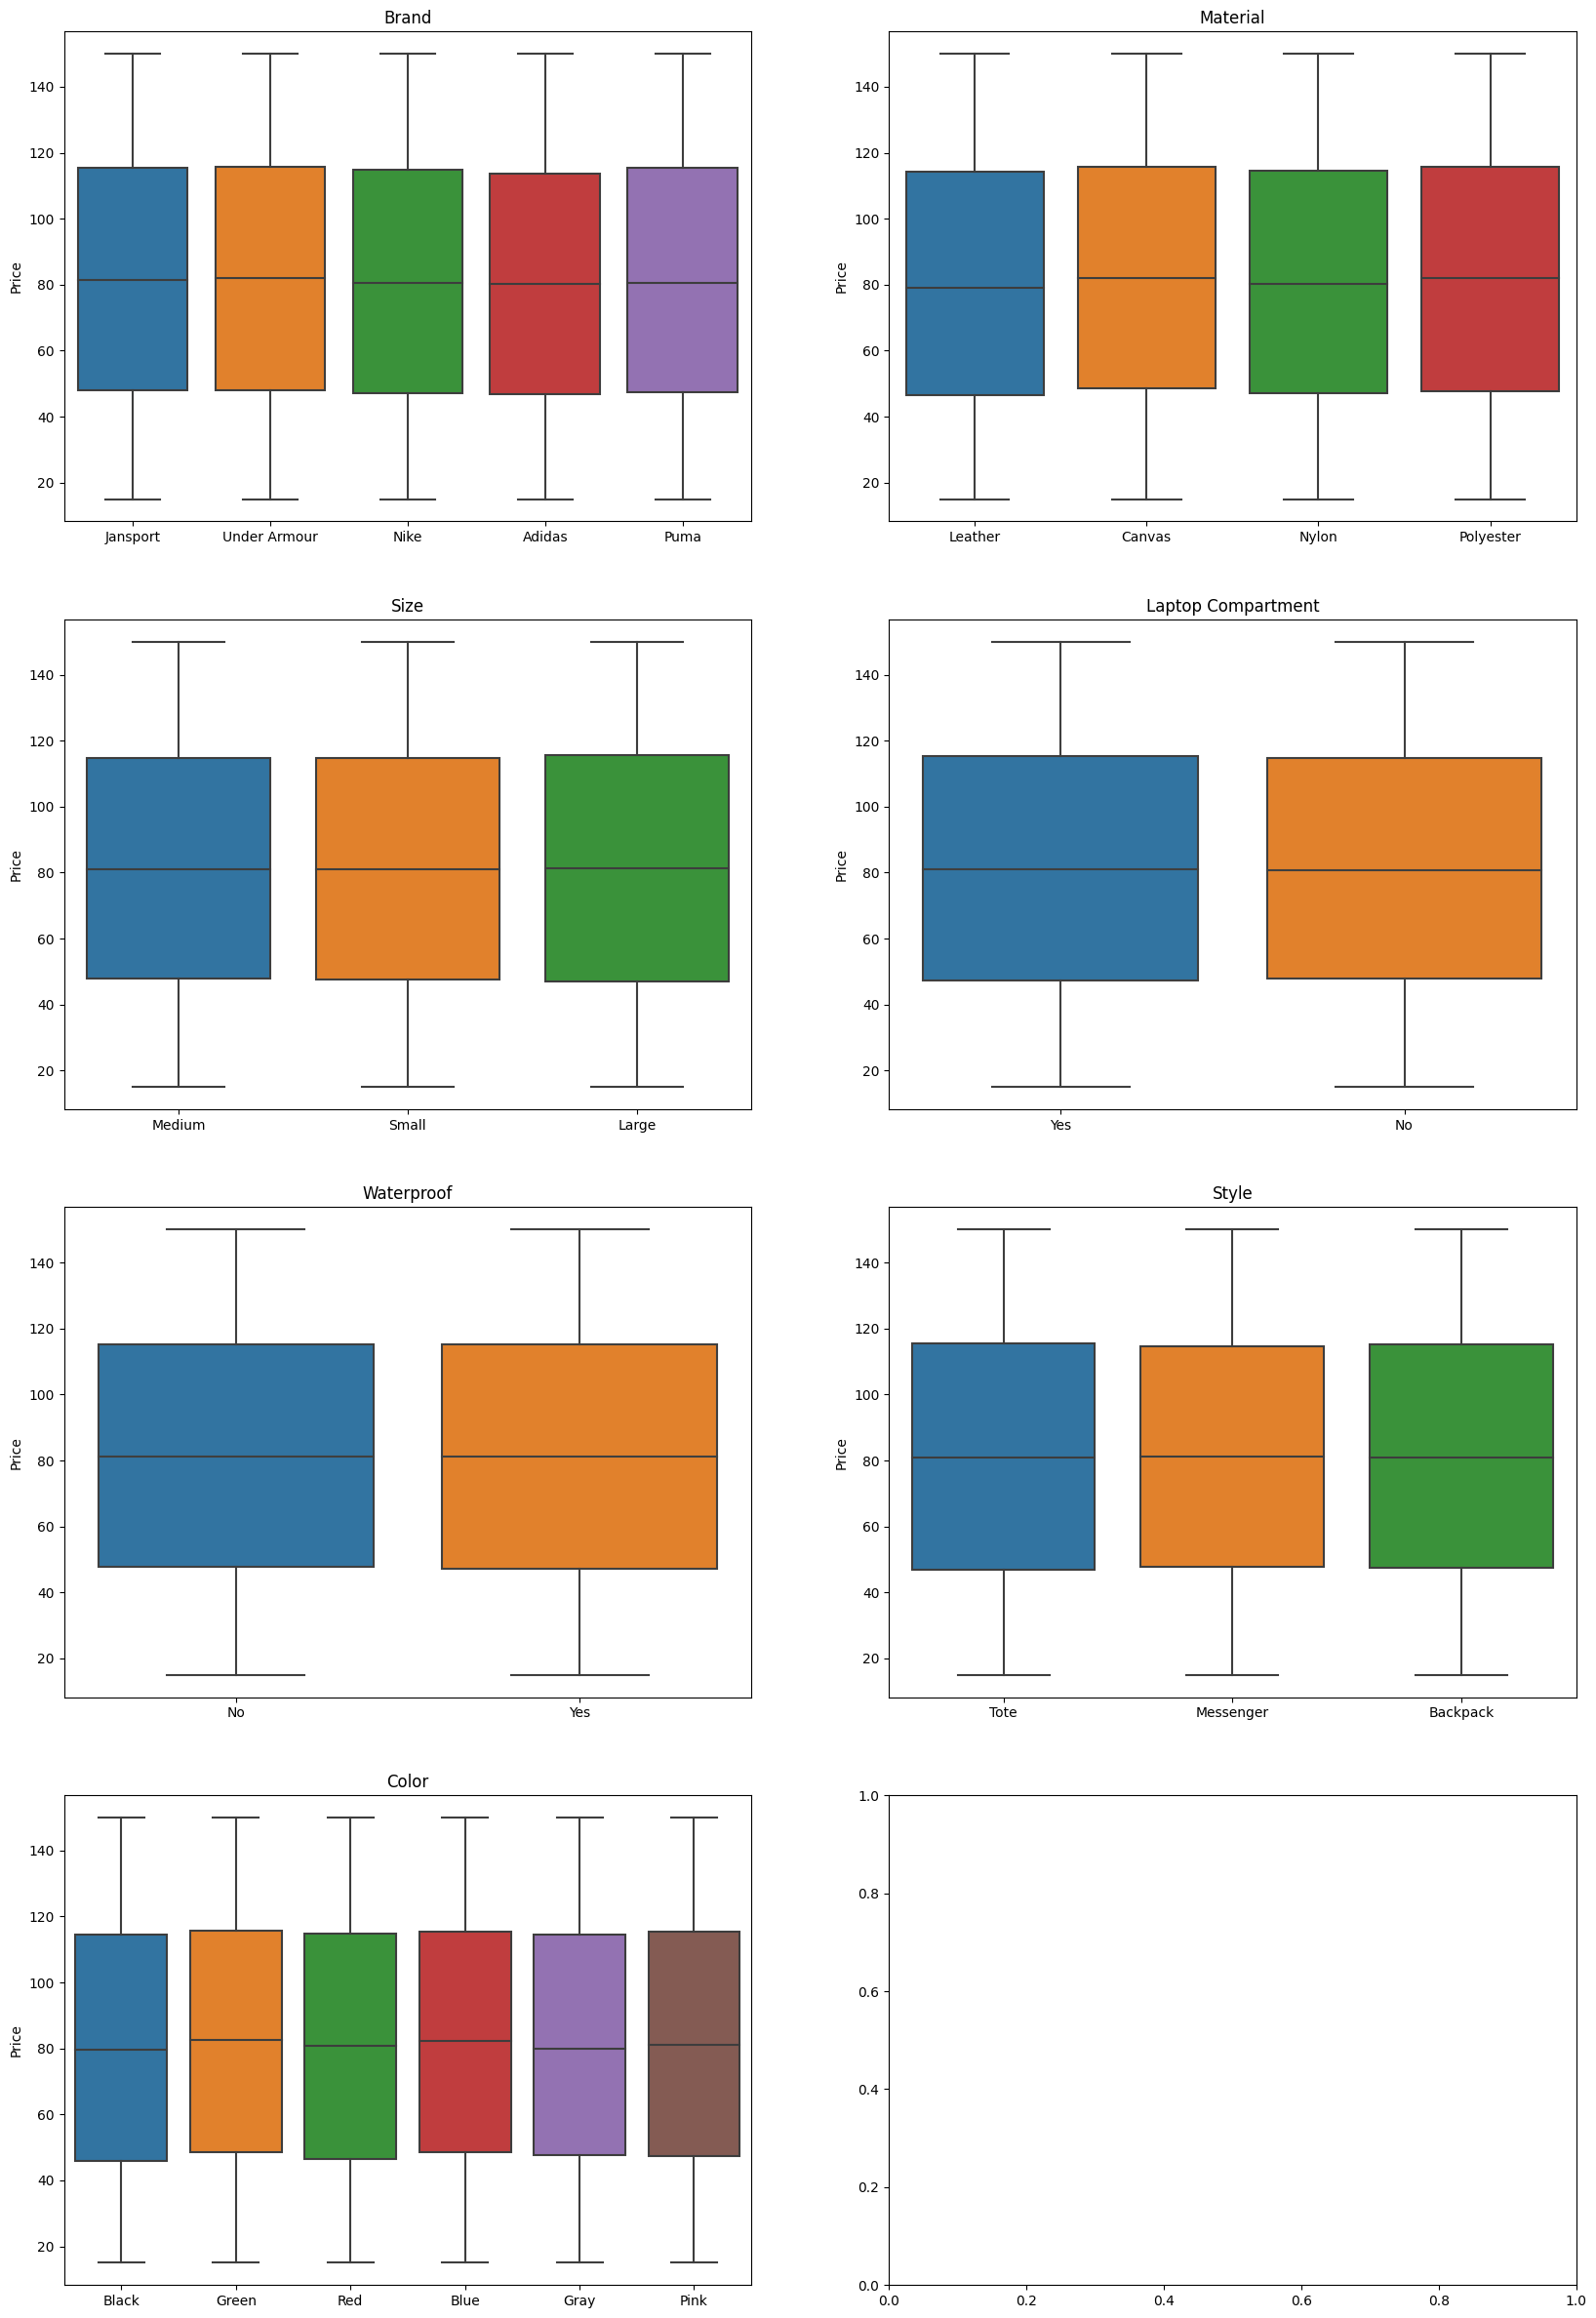

In [10]:
fig, axs = plt.subplots(4,2, figsize=(20,30))
cat_features = X_train.select_dtypes(include='object').columns
r = 0
c = 0
for feat in cat_features:
    if c == 2:
        c = 0
        r += 1
    counts = sns.boxplot(ax=axs[r,c], data=X_train, x=feat, y='Price')
    
    axs[r,c].set_title(f'{feat}')
    axs[r,c].set(xlabel=None)

  
    c += 1

## 💼 Group data by columns and get mean price

**Version 3**

After exploring the discussions it seems the target variable it just a random noise. Let's check it by grouping categorical columns and calculating average price.

In [11]:
grouped_df = pd.read_csv('/kaggle/input/playground-series-s5e2/train.csv')

In [12]:
for c in grouped_df.select_dtypes(include='object').columns:
    print(grouped_df.groupby(c)['Price'].mean())
    print()

Brand
Adidas          80.631060
Jansport        81.791276
Nike            81.319209
Puma            81.448607
Under Armour    81.976311
Name: Price, dtype: float64

Material
Canvas       82.106511
Leather      80.437883
Nylon        81.024760
Polyester    82.033315
Name: Price, dtype: float64

Size
Large     81.651446
Medium    81.343418
Small     81.424674
Name: Price, dtype: float64

Laptop Compartment
No     81.464702
Yes    81.463842
Name: Price, dtype: float64

Waterproof
No     81.572050
Yes    81.403489
Name: Price, dtype: float64

Style
Backpack     81.402513
Messenger    81.410925
Tote         81.374865
Name: Price, dtype: float64

Color
Black    80.513439
Blue     82.006994
Gray     80.851971
Green    82.381308
Pink     81.630864
Red      81.011644
Name: Price, dtype: float64



In [13]:
for c in grouped_df.select_dtypes(exclude='object').columns:
    print(grouped_df.groupby(c)['Price'].mean())
    print()

id
0         112.15875
1          68.88056
2          39.17320
3          80.60793
4          86.02312
            ...    
299995    129.99749
299996     19.85819
299997    111.41364
299998    115.89080
299999     26.72762
Name: Price, Length: 300000, dtype: float64

Compartments
1.0     81.263845
2.0     81.171776
3.0     81.332909
4.0     81.969078
5.0     81.477310
6.0     81.452368
7.0     81.440569
8.0     81.906747
9.0     80.418818
10.0    81.685283
Name: Price, dtype: float64

Weight Capacity (kg)
5.000000      78.304714
5.004444     132.156440
5.008382     143.890560
5.009731     144.075910
5.010086     104.852040
                ...    
29.996888    117.151670
29.997986     68.255628
29.998925    104.765930
29.999796     35.365320
30.000000     73.791875
Name: Price, Length: 181596, dtype: float64

Price
15.00000      15.00000
15.00634      15.00634
15.01818      15.01818
15.01980      15.01980
15.02274      15.02274
               ...    
149.97224    149.97224
149.98784    

Interesting! So average price in all groups somehow is close to average. Remind me regression towards the mean at insurance competition.

## 💻 Conclusions

From our EDA we can draw the next conclusions:
* The most popular brand is **Adidas**👟;
* The most popular material is **Polyester** 🧵;
* The most popular size is **Medium** 📏;
* On average, backpacks have **5** compartments 🎒;
* **Laptop Compartment** is the most crucial thing in a backpack 💻;
* **Waterproof** is also crucial 🌧️, which is logical for keeping laptops and other important things safe (like money 💸);
* **Messenger** backpacks are the most popular option for style 💼;
* Preferred color is **Pink** 🌸;
* Average weight capacity is **18 kg** ⚖️;
* Average price is **81$** 💵.

After exploring distributions and relationships between our features, we can conclude the following:

* Features **don't have** any correlation 📉🤷‍♀️
* Categorical features are **equally distributed** among categories 🔄📊
* Price is also **equally distributed** among different categories 💸📈

These insights suggest that our dataset maintains a balanced spread, which is promising for further modeling and analysis.

# 3️⃣ Data Preprocessing & Feature Engineering 🏗️

## 💉 Imputation of missing data
Because our dataset contains missing values, we need to fill them in so that our models can work with clear, complete data! 🚀✨ While some models can handle missing data, most of our machine learning algorithms require a dataset without any NaN's for accurate predictions.

Here's our plan for imputation:

* **Numerical Features:**
We can impute missing values with the median of the column. This approach helps maintain the overall distribution of the data 📊🔢.

* **Categorical Features:**
For categorical features, we can impute missing values using the mode (i.e., the most frequent value). This ensures that we preserve the most common category in our dataset 🏷️🔄.

By handling missing data this way, we ensure that our machine learning models receive clean and consistent data, which is crucial for robust performance and reliable predictions. 

In [14]:
# Define imputation strategies
categorical_features = ["Brand", "Material", "Size", "Laptop Compartment", "Waterproof", "Style", "Color"]
numerical_features = ["Weight Capacity (kg)"]

# Fill categorical missing values with mode (most frequent value)
for col in categorical_features:
    X_train[col].fillna(X_train[col].mode()[0], inplace=True)
    X_test[col].fillna(X_test[col].mode()[0], inplace=True)

# Fill numerical missing values with median
for col in numerical_features:
    X_train[col].fillna(X_train[col].median(), inplace=True)
    X_test[col].fillna(X_test[col].median(), inplace=True)

## 🛠️ Creating new features

Mostly with our raw features, our model can't unleash its full potential 🚫🚀. However, when we dive into feature engineering, we're essentially explaining the world to our model by revealing hidden relationships and intricate patterns in the data 🌍🔍.

By creating new features, we provide additional context and insights that raw data alone may not capture. This process allows the model to understand the nuances of the problem space, unlocking hidden potential and significantly boosting performance 📈🤖.

In other words, transforming and combining raw features is like giving the model a richer vocabulary to describe the underlying phenomena—leading to smarter predictions and improved outcomes 🎯💡✨.

In [15]:
def perform_feature_engineering(df):
    # Brand Material Interaction - Certain materials may be common for specific brands
    df['Brand_Material'] = df['Brand'] + '_' + df['Material']

    # Brand & Size Interaction - Some brands may produce only specific sizes
    df['Brand_Size'] = df['Brand'] + '_' + df['Size']

    # Has Laptop Compartment - Convert Yes/No to 1/0 for easier analysis
    df['Has_Laptop_Compartment'] = df['Laptop Compartment'].map({'Yes': 1, 'No': 0})

    # Is Waterproof - Convert Yes/No to 1/0 for easier analysis
    df['Is_Waterproof'] = df['Waterproof'].map({'Yes': 1, 'No': 0})

    # Compartments Binning - Group compartments into categories
    df['Compartments_Category'] = pd.cut(df['Compartments'], bins=[0, 2, 5, 10, np.inf], labels=['Few', 'Moderate', 'Many', 'Very Many'])

    # Weight Capacity Ratio - Normalize weight capacity using the max value
    df['Weight_Capacity_Ratio'] = df['Weight Capacity (kg)'] / df['Weight Capacity (kg)'].max()

    # Interaction Feature: Weight vs. Compartments - Some bags may hold more with less compartments
    df['Weight_to_Compartments'] = df['Weight Capacity (kg)'] / (df['Compartments'] + 1)  # Avoid division by zero

    # Style and Size Interaction - Certain styles may correlate with sizes
    df['Style_Size'] = df['Style'] + '_' + df['Size']

    return df


In [16]:
X_train_fe = perform_feature_engineering(X_train.copy())
X_test_fe = perform_feature_engineering(X_test.copy())

## ✂️ Split features and target

In [17]:
y_train = X_train_fe.Price
X_train_fe.drop('Price', axis=1, inplace=True)

## 🏷️ Encoding categorical variables

Our models only works well with number, so we need to encode our categorical features. The most common way it's ohe-hot-encoding.

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [19]:
def encode_features(X_train, X_test):
    combined_df = pd.concat([X_train, X_test], axis=0)
    categorical_columns = combined_df.select_dtypes(include=['object', 'category']).columns
    numerical_columns = combined_df.select_dtypes(exclude=['object', 'category']).columns.tolist()
    print(numerical_columns)


    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'), categorical_columns)
        ],
        remainder='passthrough' 
    )
    
    preprocessor.fit(combined_df)
    
    X_train_nan_encoded = preprocessor.transform(X_train)
    X_test_nan_encoded = preprocessor.transform(X_test)
    
    encoded_feature_names = preprocessor.get_feature_names_out()
    X_train_encoded_df = pd.DataFrame(X_train_nan_encoded, columns=encoded_feature_names)
    X_test_encoded_df = pd.DataFrame(X_test_nan_encoded, columns=encoded_feature_names)

    return X_train_encoded_df, X_test_encoded_df

In [20]:
X_train_encoded_df, X_test_encoded_df = encode_features(X_train_fe, X_test_fe)

['id', 'Compartments', 'Weight Capacity (kg)', 'Has_Laptop_Compartment', 'Is_Waterproof', 'Weight_Capacity_Ratio', 'Weight_to_Compartments']


## ✂️ Split features into train and validation set

It's a crucial step in accessing the model's perfomance. This approach assures us that we're having two separate sets: one for training and other for validation to see did our model perform well on unseen data.

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
x_train, x_val, y_train, y_val = train_test_split(X_train_encoded_df, y_train, test_size=0.15, random_state=42)

# 4️⃣ Training & Model Evaluation🤖

* **Version 3**: Simple models without tuning hyperparameters.

In this section, we'll train our machine learning model to predict the price of our backpacks! 🚀💰 Our approach will be experimental and comprehensive, as we plan to try a variety of machine learning methods to see which one works best for our data.

Here's how we'll structure this section:

**Multiple Subsections:**
Each subsection will focus on a different machine learning method. We'll experiment with various algorithms to uncover the strengths and weaknesses of each approach. For example, we might try:

* Linear Regression 📉
* Decision Trees 🌳
* Random Forests 🌲
* Gradient Boosting Machines ⚡
* Support Vector Machines 🤖
* Neural Networks 🧠

**Experimentation and Comparison:**
The goal is to try as many methods as possible, tuning them to get the best out of each. We'll keep track of:

* Hyperparameter tuning 🔧
* Training and validation performance 📊
* Potential overfitting/underfitting issues 🤔

**Evaluation Section:**
After training, we'll move on to an evaluation section where we:

* Compare the performance of each model using relevant metrics (e.g., MAE, RMSE, R²) 📈
* Analyze which model has the best performance for predicting the backpack prices 🎯
* Discuss insights and potential next steps for further improvement 🔍

By breaking down our approach into these subsections, we can clearly see how each machine learning method contributes to our overall goal. This modular strategy not only makes the notebook easier to follow but also allows us to experiment widely and pinpoint the most effective model for our problem. Let's get started and see which method will unlock the highest predictive power! 💡🔥

In [23]:
def rmse(y_true, y_pred):
    return np.sqrt(np.sum(((y_true-y_pred)**2)/len(y_true)))



scores = {'model': [],
          'model_name':[], 
         'rmse': []
         }

def add_scores_rmse(model, model_name, y_true, y_pred):
    error = rmse(y_true, y_pred)
    scores['model'].append(model)
    scores['model_name'].append(model_name)
    scores['rmse'].append(error)
    print(f'RMSE for {model_name}: {error}')
    

### 🏠 Baseline model 🏠

For baseline model we might use a DummyRegressor from scikit-learn.

A **dummy regressor** is a simple machine learning model that predicts numerical values using basic rules, without actually learning from the input data. Often it's using as a baseline, because is useful as a simple baseline to compare with other (real) regressors. It shouldn't be used it for real problems.

In [24]:
from sklearn.dummy import DummyRegressor

In [25]:
dummy = DummyRegressor()
dummy.fit(x_train, y_train)

DummyRegressor()

In [26]:
scores

{'model': [], 'model_name': [], 'rmse': []}

In [27]:
add_scores_rmse(dummy, 'DummyRegressor', y_val, dummy.predict(x_val))

RMSE for DummyRegressor: 38.948432096372215


Good, so we're having a baseline in 38.9484. Let's see if we can beat it!

### 🌲Random Forest🌲

In [28]:
from sklearn.ensemble import RandomForestRegressor

In [29]:
rf = RandomForestRegressor()
rf.fit(x_val, y_val)

RandomForestRegressor()

In [30]:
add_scores_rmse(rf, 'RandomForestRegressor', y_val, rf.predict(x_val))

RMSE for RandomForestRegressor: 14.80706798879901


### XGBoost

In [31]:
from xgboost import XGBRegressor

In [32]:
xgb = XGBRegressor()
xgb.fit(x_val, y_val)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [33]:
add_scores_rmse(xgb, 'XGBRegressor', y_val, xgb.predict(x_val))

RMSE for XGBRegressor: 34.55369091572515


# 5️⃣ Predictions & Submission 📝

In [34]:
for i in range(len(scores)):
    model = scores['model'][i]
    pred = model.predict(X_test_encoded_df)
    submission = pd.DataFrame({
        "id": X_test['id'],
        'Price': pred
    })
    submission.to_csv(index=False)
